<a href="https://colab.research.google.com/github/bio-snippets/NGS_sc/blob/main/NGS_scRNA_ivanov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#RESTART RUNTIME AFTER EXECUTING THIS CELL FOR PLOTS TO WORK
!git clone https://github.com/bio-snippets/NGS_sc.git #creates NGS_sc folder in /content
#launch notebook in /content/NGS_sc/NGS_scRNA_ivanov.ipynb after executing that
!pip install anndata
!pip install scanpy
!pip install scib
!pip uninstall matplotlib -y
#!pip install matplotlib==3.1.3
!pip install matplotlib==3.4.1

fatal: destination path 'NGS_sc' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.6.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: matplotlib 3.6.2
Uninstalling matplotlib-3.6.2:
  Successfully uninstalled matplotlib-3.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.3 MB 8.7 MB/s 


In [2]:
from IPython.display import Image, display, Markdown
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import rpy2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import time
import matplotlib.pyplot as plt
import os
import warnings
import copy
import anndata
import scanpy.external as sce
import scanpy as sc
import scib
#%load_ext rpy2.ipython

The article from which the data was used
https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-022-01051-9

# Acquiring annotation **(Demonstration only. Do not execute the code)**

This part is for demonstration how the annotation was acquired. The code below is not to be ran. (.rds file is too big to run analysis here) .rds files can be found here https://zenodo.org/record/6473604

In [ ]:
#annotation for the data consist of several overlapping parts. Combining them into a single dataset and writing in a .tsv
%R library(Seurat)
anns = {}
for filename in ['Final_Aggregated_Dura', 'Final_CD45_neg_Dura', 'Final_CD45_pos_Dura', 'Final_CD45_pos_Dura_and_Tumor']:
    filepath = f"/home/user/Uni/NGS/{filename}.rds"
    %R -i filepath
    %R Seu = readRDS(file = filepath)
    %R ann = Seu@meta.data
    %R rm(Seu)
    %R -o ann
    anns[filename] = ann

In [ ]:
ann = pd.concat(anns)
ann.to_csv('Wang_raw_annotation.tsv')

In [ ]:
ann

orig.ident  \
Final_Aggregated_Dura         MEN05_AAACCCAAGCTGGAGT-1           1   
                              MEN05_AAACCCACAGGAATAT-1           1   
                              MEN05_AAACCCATCCATCCGT-1           1   
                              MEN05_AAACGCTAGCCGCTTG-1           1   
                              MEN05_AAACGCTGTGTTCGAT-1           1   
...                                                            ...   
Final_CD45_pos_Dura_and_Tumor DURA13_TTTGGTTCAGGAATGC-1          8   
                              DURA13_TTTGGTTTCCCACTTG-1          8   
                              DURA13_TTTGTCAAGGGTCGAT-1          8   
                              DURA13_TTTGTCAGTATCTGCA-1          8   
                              DURA13_TTTGTCAGTCGTGGCT-1          8   

                                                         nCount_RNA  \
Final_Aggregated_Dura         MEN05_AAACCCAAGCTGGAGT-1       1363.0   
                              MEN05_AAACCCACAGGAATAT-1      35921.0   
                              MEN05_AAACCCATCCATCCGT-1       8695.0   
                              MEN05_AAACGCTAGCCGCTTG-1      16704.0   
                              MEN05_AAACGCTGTGTTCGAT-1      12264.0   
...                                                             ...   
Final_CD45_pos_Dura_and_Tumor DURA13_TTTGGTTCAGGAATGC-1      5011.0   
                              DURA13_TTTGGTTTCCCACTTG-1      6158.0   
                              DURA13_TTTGTCAAGGGTCGAT-1      2079.0   
                              DURA13_TTTGTCAGTATCTGCA-1      5647.0   
                              DURA13_TTTGTCAGTCGTGGCT-1      2341.0   

                                                         nFeature_RNA Batch  \
Final_Aggregated_Dura         MEN05_AAACCCAAGCTGGAGT-1            761     1   
                              MEN05_AAACCCACAGGAATAT-1           5238     1   
                              MEN05_AAACCCATCCATCCGT-1           2168     1   
                              MEN05_AAACGCTAGCCGCTTG-1           3536     1   
                              MEN05_AAACGCTGTGTTCGAT-1           2870     1   
...                                                               ...   ...   
Final_CD45_pos_Dura_and_Tumor DURA13_TTTGGTTCAGGAATGC-1          1871     8   
                              DURA13_TTTGGTTTCCCACTTG-1          2105     8   
                              DURA13_TTTGTCAAGGGTCGAT-1           875     8   
                              DURA13_TTTGTCAGTATCTGCA-1          1928     8   
                              DURA13_TTTGTCAGTCGTGGCT-1          1015     8   

                                                         Sample  percent.mito  \
Final_Aggregated_Dura         MEN05_AAACCCAAGCTGGAGT-1    MEN05      0.021277   
                              MEN05_AAACCCACAGGAATAT-1    MEN05      0.029509   
                              MEN05_AAACCCATCCATCCGT-1    MEN05      0.027947   
                              MEN05_AAACGCTAGCCGCTTG-1    MEN05      0.021671   
                              MEN05_AAACGCTGTGTTCGAT-1    MEN05      0.048516   
...                                                         ...           ...   
Final_CD45_pos_Dura_and_Tumor DURA13_TTTGGTTCAGGAATGC-1  DURA13      0.021353   
                              DURA13_TTTGGTTTCCCACTTG-1  DURA13      0.032153   
                              DURA13_TTTGTCAAGGGTCGAT-1  DURA13      0.039923   
                              DURA13_TTTGTCAGTATCTGCA-1  DURA13      0.051178   
                              DURA13_TTTGTCAGTCGTGGCT-1  DURA13      0.020504   

                                                         percent.ribo  \
Final_Aggregated_Dura         MEN05_AAACCCAAGCTGGAGT-1       0.038885   
                              MEN05_AAACCCACAGGAATAT-1       0.186019   
                              MEN05_AAACCCATCCATCCGT-1       0.263600   
                              MEN05_AAACGCTAGCCGCTTG-1       0.199713   
                              MEN05_AAACGCTGTGTTCGAT-1       0.168624   
..

In [ ]:
del ann

# Create annData

Researches provided counts for all the 4 but I'm the most interested in 'Final_CD45_pos_Dura_and_Tumor'

Paragraph from the study about this data: <br>
"Similarly, four paired dura and meningioma samples were processed together using the Seurat R package. Similar filtering criteria were applied, but samples were merged, rather than batched and integrated (because the same sequencing technology was used), then normalized."

Thus, there was no batch_correction, and preprocessing of data can be compared.

In [2]:
#setting the woriknig folder
current_folder = os.getcwd()
current_folder

'/content'

In [3]:
os.chdir(current_folder + '/NGS_sc')

In [4]:
#first, lets's download the file with raw counts
!wget https://zenodo.org/record/6473604/files/RawData_210723.zip?download=1

--2022-12-10 13:36:10--  https://zenodo.org/record/6473604/files/RawData_210723.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349352104 (333M) [application/octet-stream]
Saving to: ‘RawData_210723.zip?download=1’

RawData_210723.zip? 100%[===================>] 333.17M  18.0MB/s    in 35s     

2022-12-10 13:36:47 (9.42 MB/s) - ‘RawData_210723.zip?download=1’ saved [349352104/349352104]



In [5]:
#unzipping it
!unzip RawData_210723.zip?download=1

Archive:  RawData_210723.zip?download=1
  inflating: Raw_Files/scRNA_Raw_Files.7z  
  inflating: Raw_Files/Raw_VDJ_Files.7z  


In [6]:
#unzipping subfolder
!apt install p7zip
!7za x Raw_Files/scRNA_Raw_Files.7z
#it creates NGS_sc/scRNA_Raw_Files subfolder. We will need this one!

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-6).
p7zip set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 349080910 bytes (333 MiB)

Extracting archive: Raw_Files/scRNA_Raw_Files.7z
--
Path = Raw_Files/scRNA_Raw_Files.7z
Type = 7z
Physical Size = 349080910
Headers Size = 975
Method = LZMA2:24
Solid = +
Blocks = 1

  0%     28% 33 - scRNA_Raw_Files/MEN08/filtered_feature_bc_matrix/matrix.mtx.gz

In [70]:
ann = pd.read_csv('Wang_raw_annotation.tsv')
ann_selected = ann[ann['Unnamed: 0'] == 'Final_CD45_pos_Dura_and_Tumor']
ann_selected = ann_selected.rename(columns = {'Unnamed: 1':'Barcode'})
ann_selected = ann_selected.loc[:,['Barcode','Batch', 'seurat_clusters', 'Sample', 'seurat_clusters_modified_new', 'Final_celltypes']]
ann_selected = ann_selected.set_index('Barcode')
del ann
ann_selected.to_csv('ann_selected.tsv', sep = '\t')
ann_selected

,Batch,seurat_clusters,Sample,seurat_clusters_modified_new,Final_celltypes
Barcode,,,,,
MEN08_AAACCTGCAGAGCCAA-1,1,20,MEN08,1.0,13.0
MEN08_AAACCTGGTTCAACCA-1,1,16,MEN08,17.0,11.0
MEN08_AAACCTGTCCAAACTG-1,1,18,MEN08,19.0,2.0
MEN08_AAACCTGTCCACTGGG-1,1,2,MEN08,3.0,10.0
MEN08_AAACGGGCAATACGCT-1,1,5,MEN08,6.0,9.0
...,...,...,...,...,...
DURA13_TTTGGTTCAGGAATGC-1,8,1,DURA13,2.0,1.0
DURA13_TTTGGTTTCCCACTTG-1,8,1,DURA13,2.0,1.0
DURA13_TTTGTCAAGGGTCGAT-1,8,13,DURA13,14.0,8.0


In [71]:
ann_selected[['seurat_clusters']].value_counts()

seurat_clusters
1                  1688
2                  1621
3                  1391
4                  1105
5                   817
6                   805
7                   786
8                   584
9                   543
10                  459
11                  458
12                  418
13                  321
14                  306
15                  276
16                  269
17                  233
18                  199
19                  138
20                   83
21                   81
dtype: int64

In [72]:
ann_selected['Sample'].unique()

array(['MEN08', 'MEN09', 'MEN10', 'MEN13', 'DURA08', 'DURA09', 'DURA10',
       'DURA13'], dtype=object)

We have 8 samples, they correspond to their count matrix. Let's get those.

In [73]:
samples = list(ann_selected['Sample'].unique())
runs = ['MEN08_TUMOR', 'MEN09_TUMOR','MEN10_TUMOR','MEN13_TUMOR','MEN08', 'MEN09','MEN10','MEN13',]
folders_to_samples= dict(zip(runs,samples))
folders_to_samples

{'MEN08_TUMOR': 'MEN08',
 'MEN09_TUMOR': 'MEN09',
 'MEN10_TUMOR': 'MEN10',
 'MEN13_TUMOR': 'MEN13',
 'MEN08': 'DURA08',
 'MEN09': 'DURA09',
 'MEN10': 'DURA10',
 'MEN13': 'DURA13'}

In [74]:
#it takes about 5 minutes to read all the 8
data = {}
for run in runs:
    adata = sc.read_10x_mtx(f'scRNA_Raw_Files/{run}/filtered_feature_bc_matrix/')
    data[folders_to_samples[run]] = adata
del adata

In [75]:
data #8 adata objects

{'MEN08': AnnData object with n_obs × n_vars = 8369 × 33538
     var: 'gene_ids', 'feature_types',
 'MEN09': AnnData object with n_obs × n_vars = 8719 × 33538
     var: 'gene_ids', 'feature_types',
 'MEN10': AnnData object with n_obs × n_vars = 2692 × 33538
     var: 'gene_ids', 'feature_types',
 'MEN13': AnnData object with n_obs × n_vars = 8572 × 33538
     var: 'gene_ids', 'feature_types',
 'DURA08': AnnData object with n_obs × n_vars = 7279 × 33538
     var: 'gene_ids', 'feature_types',
 'DURA09': AnnData object with n_obs × n_vars = 4406 × 33538
     var: 'gene_ids', 'feature_types',
 'DURA10': AnnData object with n_obs × n_vars = 2113 × 33538
     var: 'gene_ids', 'feature_types',
 'DURA13': AnnData object with n_obs × n_vars = 4885 × 33538
     var: 'gene_ids', 'feature_types'}

In [76]:
#now creating a single AnnData object from it with barcodes corresponding to barcodes from annotation
mdata = copy.deepcopy(data) #modified data
for sample in samples:
    mdata[sample].obs.index = sample + '_' + mdata[sample].obs.index

In [77]:
mdata['MEN08'].obs.head()

""
MEN08_AAACCTGAGTACTTGC-1
MEN08_AAACCTGAGTCACGCC-1
MEN08_AAACCTGAGTTTAGGA-1
MEN08_AAACCTGCACATTAGC-1
MEN08_AAACCTGCAGAGCCAA-1


In [78]:
adata = anndata.concat([mdata[sample] for sample in samples])
adata

AnnData object with n_obs × n_vars = 47035 × 33538

In [79]:
adata.write('combined_adata', compression = 'gzip')
del adata
del data
del mdata
import gc
gc.collect()

In [4]:
os.chdir('/content/NGS_sc')

In [5]:
adata = sc.read_h5ad('combined_adata')
ann_selected = pd.read_csv('ann_selected.tsv', sep = '\t', index_col = 0)

In [6]:
#check the number of cells in annotation and in raw data
adata.obs.shape, ann_selected.shape

((47035, 0), (12581, 5))

As we can see, there is much more cells in raw data compared to the number of cells. It's only logical since some cells probably were excluded after the quality control. 

First I'm going to do the Quality Control and analysis. And after that I'm going to compare clusters between my analysis and annotation only for those cells which are present in the annotation. 

In [7]:
len(set(adata.obs.index) & set(ann_selected.index))

12581

In [8]:
adata.obs.index.value_counts()

MEN08_AAACCTGAGTACTTGC-1     1
DURA08_CGGACGTCATACCATG-1    1
DURA08_CGGACGTGTAAAGGAG-1    1
DURA08_CGGACGTGTCGACTAT-1    1
DURA08_CGGACGTGTCGCTTCT-1    1
                            ..
MEN09_TCAGCAACACCAGATT-1     1
MEN09_TCAGCAACAGGCTGAA-1     1
MEN09_TCAGCAACATGCAACT-1     1
MEN09_TCAGCAACATTAGCCA-1     1
DURA13_TTTGTCATCTCCTATA-1    1
Length: 47035, dtype: int64

As we can see, all cells from annotation can be found in raw data. And all the barcode identifiers are unique. 

I'll do analysis for annotated cells (the cells researchers actually analyzed in this part of study)

In [9]:
adata = adata[ann_selected.index]

The dataset and the annotation are ready for the analysis

# Quality Control

In [10]:
adata.var["mt"] = adata.var_names.str.startswith("MT-") #labeling mitochondrial genes
adata.var.sample(2)

<ipython-input-10-e76133e1afc0>:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT-") #labeling mitochondrial genes


,mt
CCDC167,False
AC025437.4,False


In [11]:
#doing quality control
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
adata.obs.head()

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
MEN08_AAACCTGCAGAGCCAA-1,1211,4329.0,60.0,1.386001
MEN08_AAACCTGGTTCAACCA-1,535,877.0,35.0,3.990878
MEN08_AAACCTGTCCAAACTG-1,664,2302.0,102.0,4.430930
MEN08_AAACCTGTCCACTGGG-1,616,1971.0,21.0,1.065449
MEN08_AAACGGGCAATACGCT-1,624,1615.0,41.0,2.538700


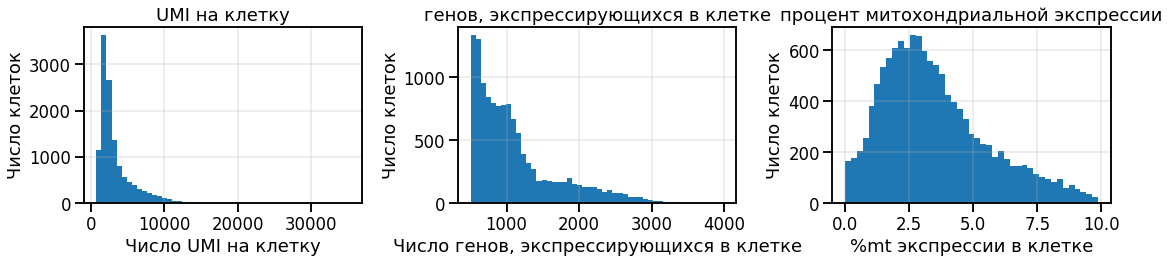

In [12]:
#starting from here and thereafter some cells are copied from seminar's notebook

def pic():
    warnings.filterwarnings("ignore")

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))

    # Отрисовываем распределение общего числа UMI
    sns.distplot(adata.obs["total_counts"], kde=False, ax=axes[0], hist_kws={"alpha":1})
    axes[0].set_xlabel("Число UMI на клетку")
    axes[0].set_ylabel("Число клеток")
    axes[0].set_title("UMI на клетку")
    axes[0].grid(alpha=0.3)

    # Отрисовываем распределение числа генов по клеткам
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, ax=axes[1], hist_kws={"alpha":1})
    axes[1].set_xlabel("Число генов, экспрессирующихся в клетке")
    axes[1].set_ylabel("Число клеток")
    axes[1].set_title("генов, экспрессирующихся в клетке")
    axes[1].grid(alpha=0.3)

    # Отрисовываем распределение митохондриальной экспрессии
    sns.distplot(adata.obs["pct_counts_mt"], kde=False, ax=axes[2], hist_kws={"alpha":1})
    axes[2].set_xlabel("%mt экспрессии в клетке")
    axes[2].set_ylabel("Число клеток")
    axes[2].set_title("процент митохондриальной экспрессии")
    axes[2].grid(alpha=0.3)

    fig.tight_layout()

    warnings.filterwarnings('default')
pic()

The data is far from perfect. We will have to do filtering.

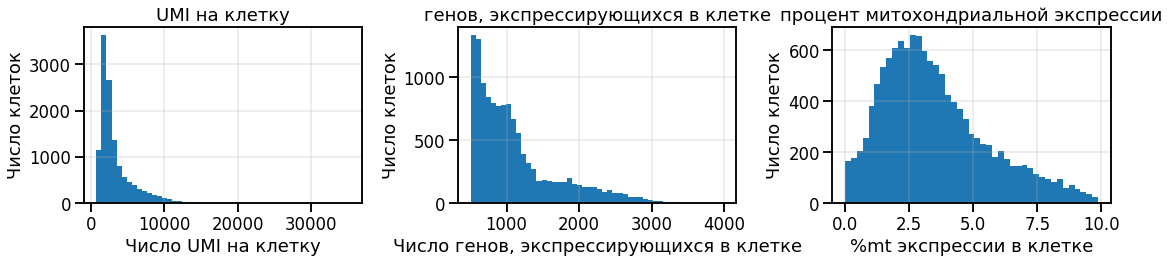

In [13]:
#on the graph below one can see that UMI is already filtered, so the plots will be the same
adata = adata[adata.obs.total_counts >= 100] #minimal counts filter
pic()

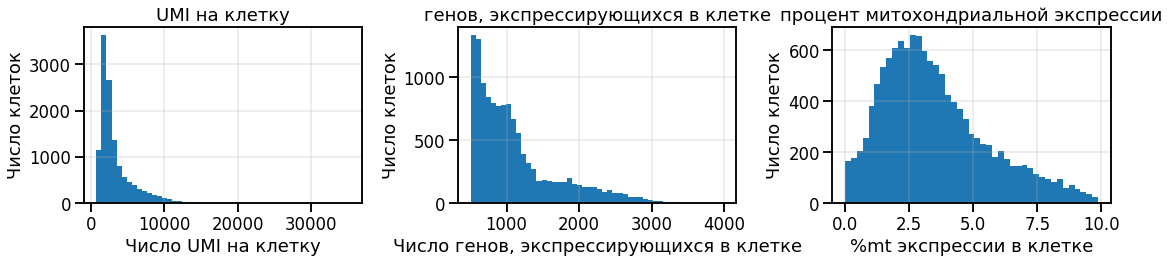

In [14]:
adata = adata[adata.obs.n_genes_by_counts >= 500] # filtering by number of genes
adata = adata[adata.obs.pct_counts_mt <= 20] # max mt content filter
#looks like researchers usde the wary same threshold and even stricter for mt (mt < 10)
pic()

Still looks noisy but not sure how to separate them better

Now, filtering by dublets

In [ ]:
!pip install scrublet

In [15]:
sce.pp.scrublet(adata)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.3%


/usr/local/lib/python3.8/dist-packages/scanpy/external/pp/_scrublet.py:271: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = scrubbed['obs']['doublet_score']


Very few were filtered out

In [16]:
adata = adata[~adata.obs.predicted_doublet]
print(adata)

View of AnnData object with n_obs × n_vars = 12574 × 33538
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'


Now, checking variation

In [17]:
adata.layers["counts"] = adata.X.copy()

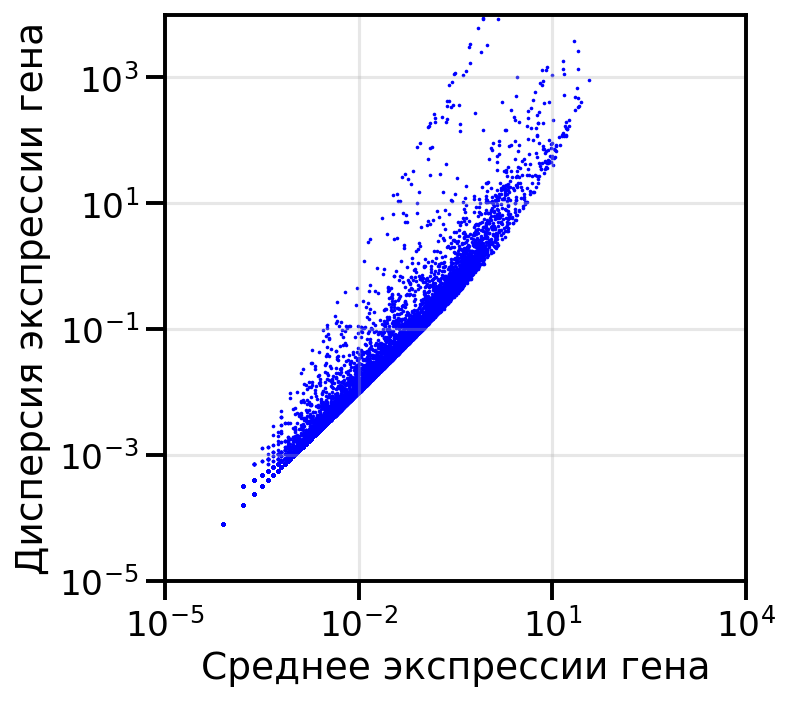

In [18]:
variance = np.var(adata.layers["counts"].A, axis=0)
mean = np.mean(adata.layers["counts"].A, axis=0)

mean = mean[variance > 0]
variance = variance[variance > 0]

mean = np.asarray(mean).reshape(-1)
variance = np.asarray(variance).reshape(-1)

fig, ax = plt.subplots(dpi=150, figsize=(5, 5))

sns.scatterplot(x=mean, y=variance, linewidth=0, s=3, color="blue", ax=ax)
ax.set_xlabel("Среднее экспрессии гена"); ax.set_ylabel("Дисперсия экспрессии гена")
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlim(0.00001, 10000); ax.set_ylim(0.00001, 10000)

ax.grid(alpha=0.3)

Some outliers can be observed in form of 'tail' above the main curve 

In [19]:
#copying adata for future use
adata_preint = adata.copy() #adata preintegrated

# log1p and umap

In [20]:
print("Суммы UMI на клетку до нормировки:", adata.X.sum(axis=1).T)

sc.pp.normalize_total(adata)
print("Суммы UMI на клетку после нормировки:", adata.X.sum(axis=1).T)

Суммы UMI на клетку до нормировки: [[4329.  877. 2302. ... 2129. 5686. 2367.]]
Суммы UMI на клетку после нормировки: [[2440.0002 2439.9998 2440.     ... 2439.9998 2440.     2440.    ]]


In [21]:
sc.pp.log1p(adata) 

In [22]:
#finding highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    layer="counts",
    flavor="seurat_v3",
)

In [23]:
adata.var.sample(4)

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm
LINC01525,False,0,0.000000,100.000000,0.0,False,NaN,0.000000,0.000000,0.000000
PRB2,False,4,0.000318,99.968206,4.0,False,NaN,0.000318,0.000318,0.954244
FBXO33,False,494,0.040776,96.073444,513.0,False,NaN,0.040798,0.042159,0.834584
AL353596.1,False,20,0.002702,99.841030,34.0,True,749.0,0.002704,0.009696,2.005781


In [24]:
adata.raw = adata #snapshot of a data at current time
adata = adata[:, adata.var.highly_variable] # leaving only HVG in current analysis
print(adata)

View of AnnData object with n_obs × n_vars = 12574 × 3000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scrublet', 'log1p', 'hvg'
    layers: 'counts'


Next, scaling the data to control the dispersion

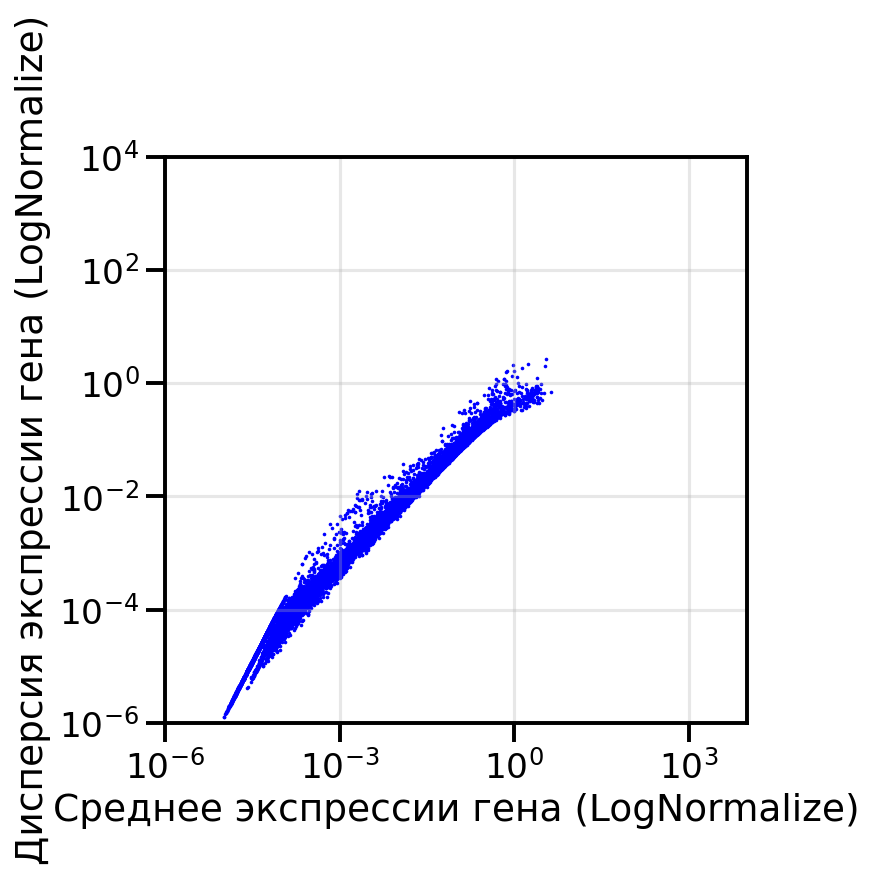

In [25]:
#Showing exression after log-transformation
variance = np.var(adata.raw.X.todense(), axis=0)
mean = np.mean(adata.raw.X.todense(), axis=0)

mean = mean[variance > 0]
variance = variance[variance > 0]

mean = np.squeeze(np.asarray(mean))
variance = np.squeeze(np.asarray(variance))

fig, ax = plt.subplots(dpi=150, figsize=(5, 5))

sns.scatterplot(x=mean, y=variance, linewidth=0, s=3, color="blue", ax=ax)
ax.set_xlabel("Среднее экспрессии гена (LogNormalize)"); ax.set_ylabel("Дисперсия экспрессии гена (LogNormalize)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.000001, 10000); ax.set_ylim(0.000001, 10000)

ax.grid(alpha=0.3)

Scaling. Comparing expressions before and after the scaling

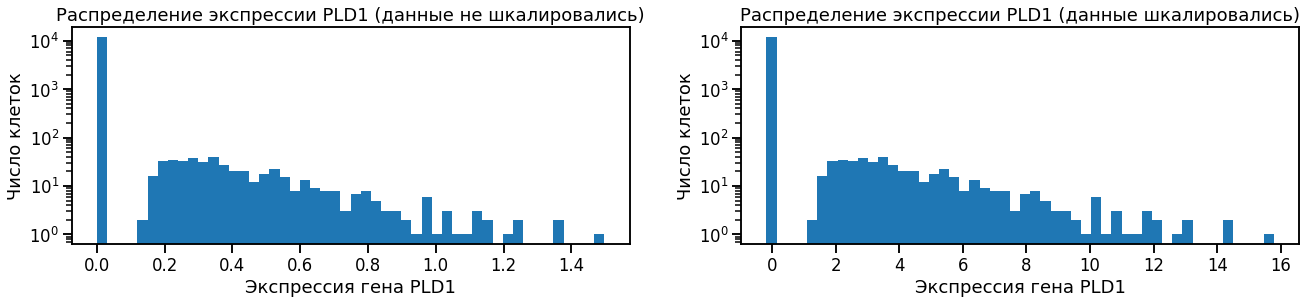

In [26]:
warnings.filterwarnings('ignore')
    
sc.pp.scale(adata) # Шкалирование

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(22, 4)) # Создаём сетку, чтобы отрисовать два графика

# Отрисовываем распределение экспрессии гена CD3E на нешкалированных данных
sns.distplot(adata.raw[:, "PLD1"].X.todense(), kde=False, ax=axs[0], hist_kws={"alpha":1})
axs[0].set_xlabel("Экспрессия гена PLD1")
axs[0].set_ylabel("Число клеток")
axs[0].set_title("Распределение экспрессии PLD1 (данные не шкалировались)")
axs[0].set_yscale("log")

# Отрисовываем распределение экспрессии гена CD3E на нешкалированных данных
sns.distplot(adata[:, "PLD1"].X, kde=False, ax=axs[1], hist_kws={"alpha":1})
axs[1].set_xlabel("Экспрессия гена PLD1")
axs[1].set_ylabel("Число клеток")
axs[1].set_title("Распределение экспрессии PLD1 (данные шкалировались)")
axs[1].set_yscale("log")

warnings.filterwarnings('default')

# Dimensionality reduction, visualization, clustering

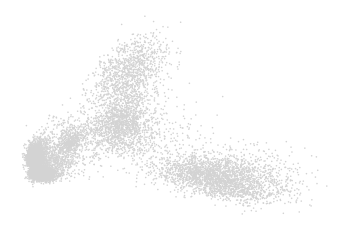

In [27]:
#compute and draw pca
sc.tl.pca(adata)
sc.pl.pca(adata, frameon=False)

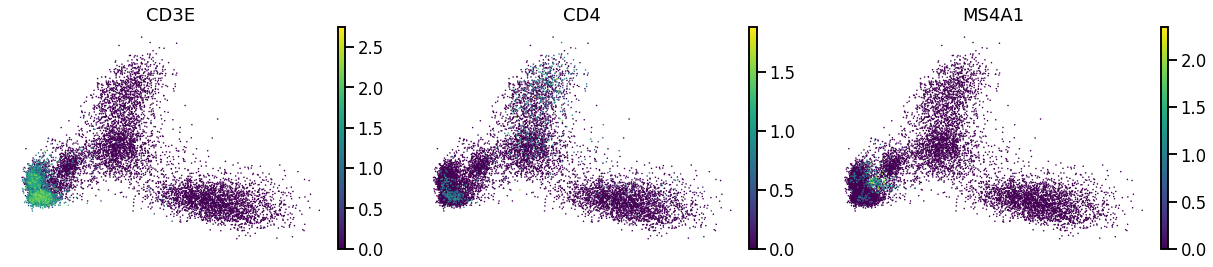

In [28]:
#pca by genes
sc.pl.pca(adata, color=["CD3E", "CD4", "MS4A1"], frameon=False)

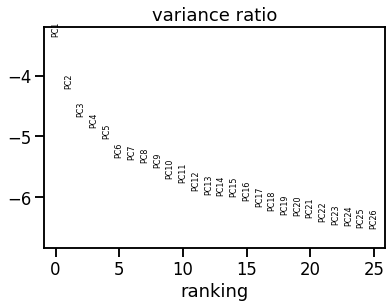

In [29]:
#elbow plot
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=25)

16 components to use

In [30]:
#t-SNE and UMAP on graph
sc.pp.neighbors(adata, n_pcs=16, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.5)
sc.tl.tsne(adata, n_pcs=15) 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:title={'center':'t-SNE'}, xlabel='tSNE1', ylabel='tSNE2'>

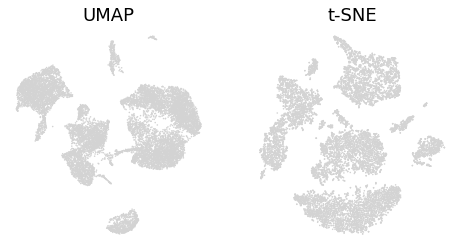

In [31]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
sc.pl.umap(adata, frameon=False, ax=axs[0], title="UMAP", show=False)
sc.pl.tsne(adata, frameon=False, ax=axs[1], title="t-SNE", show=False)

In [32]:
#Leiden clustering https://www.nature.com/articles/s41598-019-41695-z
sc.tl.leiden(adata)

<AxesSubplot:title={'center':'t-SNE'}, xlabel='tSNE1', ylabel='tSNE2'>

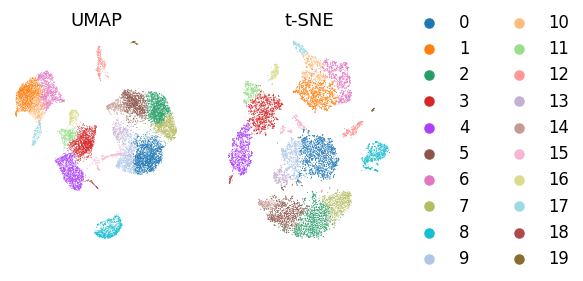

In [33]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7, 4))
sc.pl.umap(adata, color="leiden", frameon=False, ax=axs[0], title="UMAP", show=False, legend_loc=None, s=3) # Отрисовываем UMAP
sc.pl.tsne(adata, color="leiden", frameon=False, ax=axs[1], title="t-SNE", show=False, s=3) # Отрисовываем t-SNE

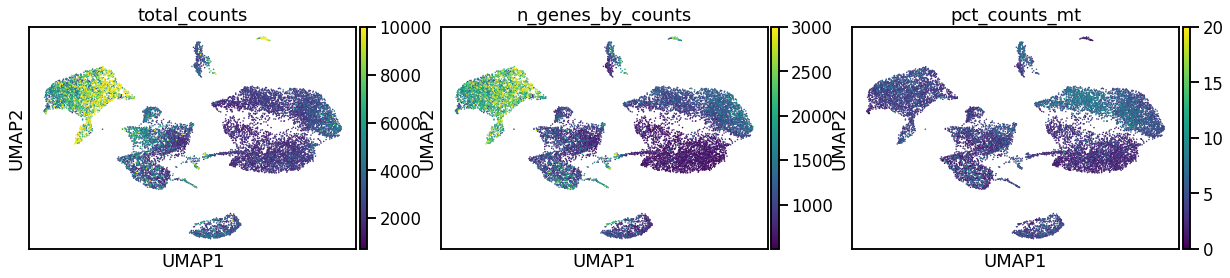

In [34]:
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "pct_counts_mt"], vmax=[10000, 3000, 20])

Let's compare my clusters and clusters of researchers visually

In [35]:
adata.obs['seurat_clusters'] = ann_selected['seurat_clusters'].astype('category')

<AxesSubplot:title={'center':'t-SNE (their labels)'}, xlabel='tSNE1', ylabel='tSNE2'>

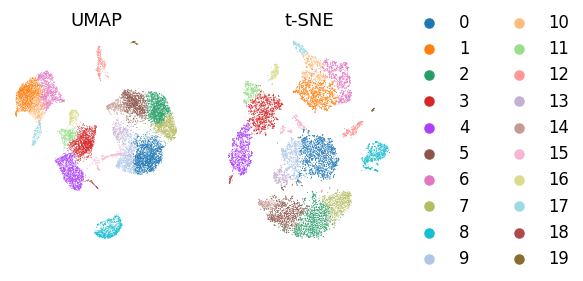

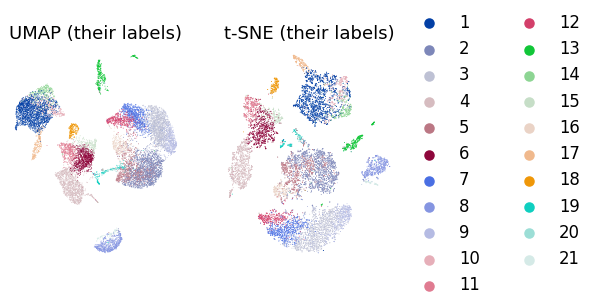

In [36]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7, 4))
sc.pl.umap(adata, color="leiden", frameon=False, ax=axs[0], title="UMAP", show=False, legend_loc=None, s=3) # Отрисовываем UMAP
sc.pl.tsne(adata, color="leiden", frameon=False, ax=axs[1], title="t-SNE", show=False, s=3) # Отрисовываем t-SNE

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7, 4))
sc.pl.umap(adata, color='seurat_clusters', frameon=False, ax=axs[0], title="UMAP (their labels)", show=False, legend_loc=None, s=3) # Отрисовываем UMAP
sc.pl.tsne(adata, color='seurat_clusters', frameon=False, ax=axs[1], title="t-SNE (their labels)", show=False, s=3) # Отрисовываем t-SNE

Let's compare my clusters to the clusters of researchers using confusion matrix

In [37]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,doublet_score,predicted_doublet,leiden,seurat_clusters
MEN08_AAACCTGCAGAGCCAA-1,1211,4329.0,60.0,1.386001,0.061019,False,15,20
MEN08_AAACCTGGTTCAACCA-1,535,877.0,35.0,3.990878,0.015258,False,13,16
MEN08_AAACCTGTCCAAACTG-1,664,2302.0,102.0,4.430930,0.026844,False,16,18
MEN08_AAACCTGTCCACTGGG-1,616,1971.0,21.0,1.065449,0.018967,False,0,2
MEN08_AAACGGGCAATACGCT-1,624,1615.0,41.0,2.538700,0.034580,False,9,5
...,...,...,...,...,...,...,...,...
DURA13_TTTGGTTCAGGAATGC-1,1896,5037.0,107.0,2.124280,0.057851,False,6,1
DURA13_TTTGGTTTCCCACTTG-1,2133,6187.0,198.0,3.200259,0.109375,False,1,1
DURA13_TTTGTCAAGGGTCGAT-1,898,2129.0,83.0,3.898544,0.042783,False,12,13
DURA13_TTTGTCAGTATCTGCA-1,1966,5686.0,289.0,5.082659,0.092150,False,10,17


In [38]:
df_heatmap = pd.DataFrame({'leiden': adata.obs['leiden'].astype('int'),
                           'seurat_clusters':ann_selected.loc[adata.obs.index]['seurat_clusters'].astype('int')},
                          index = adata.obs.index)

In [39]:
pd.set_option('display.max_columns', 25)
def confusion_matrix(df: pd.DataFrame, col1: str, col2: str): #https://gist.github.com/Mlawrence95/f697aa939592fa3ef465c05821e1deed
    return (
            df
            .groupby([col1, col2])
            .size()
            .unstack(fill_value=0)
            )

In [40]:
cf_matrix = confusion_matrix(df_heatmap, 'leiden', 'seurat_clusters')
cf_matrix

seurat_clusters,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
leiden,,,,,,,,,,,,,,,,,,,,,
0,0,1326,4,0,296,0,0,0,2,0,1,0,2,0,0,7,0,0,2,1,0
1,972,0,0,1,0,0,0,0,0,144,0,0,0,58,0,0,1,0,0,0,0
2,2,12,995,0,1,0,46,0,95,0,0,1,0,0,0,0,0,0,1,0,0
3,0,0,0,11,0,767,0,0,0,1,121,0,0,0,240,0,0,0,1,0,0
4,0,1,0,1021,1,27,0,0,0,0,10,0,1,0,1,0,0,0,0,0,0
5,0,15,75,0,17,0,725,0,1,0,0,156,0,0,0,3,0,0,0,1,0
6,296,0,0,0,0,0,0,0,0,307,0,0,0,241,2,0,2,0,0,0,0
7,0,13,313,0,2,0,2,0,445,0,0,0,0,0,0,0,0,0,0,0,0
8,0,14,0,1,1,0,0,584,0,0,0,0,0,0,0,0,0,0,2,0,80


As one can see, there is some difference in clustering, even though there is a lot of similarity. Now trying to identify cell types and compare them to original cell types.

# Determining cell's populations

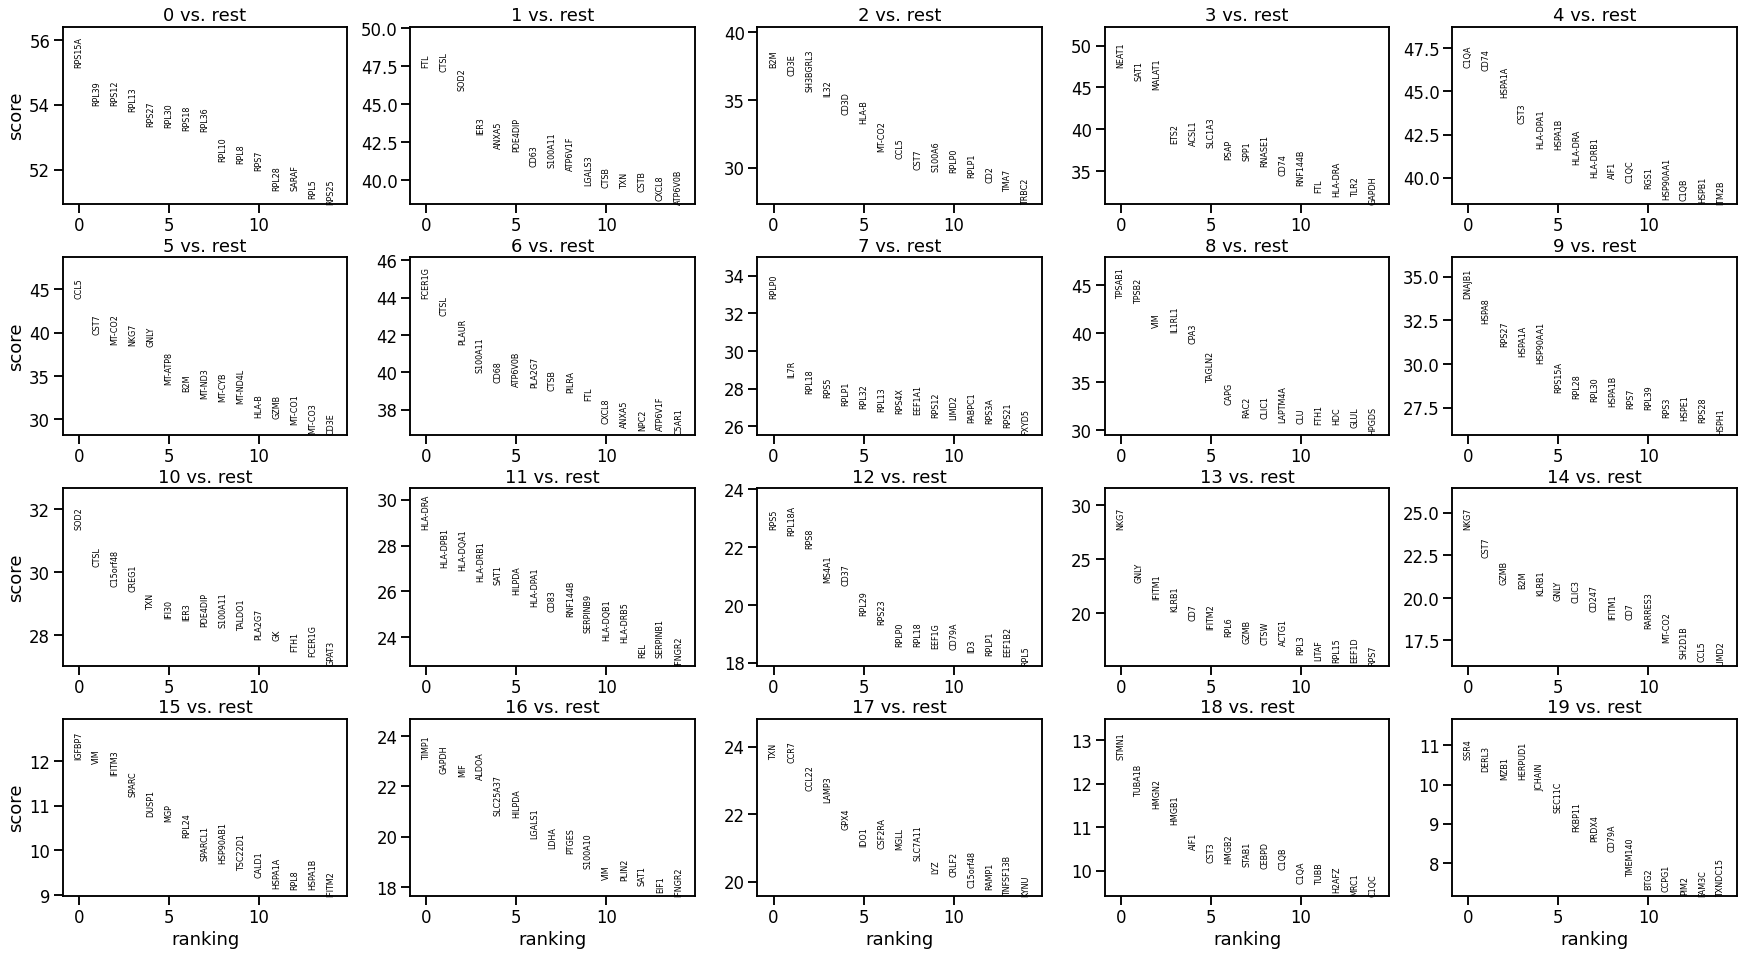

In [41]:
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False, ncols=5)
warnings.filterwarnings('default')

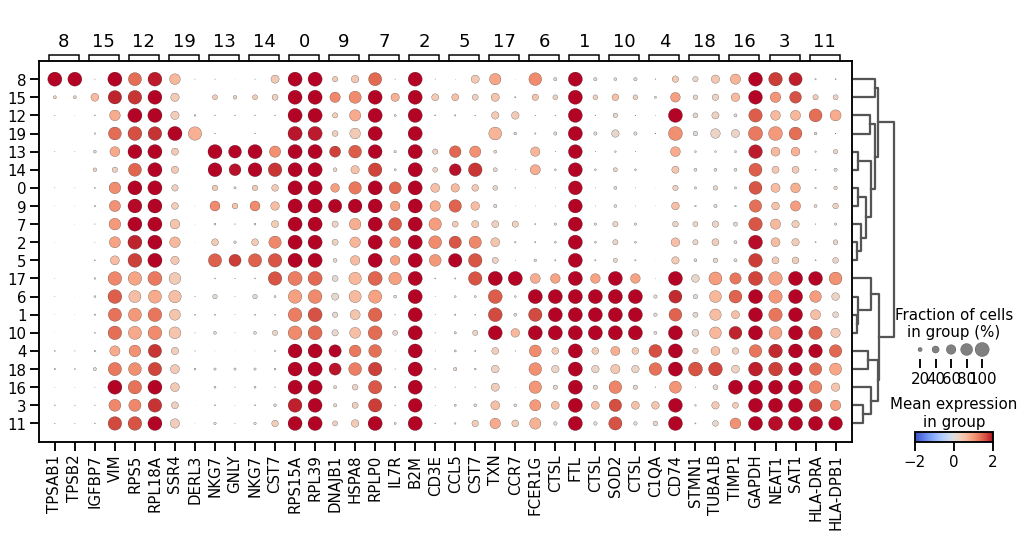

In [42]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=2, 
    vmin=-2,
    vmax=2,
    cmap="coolwarm",
)

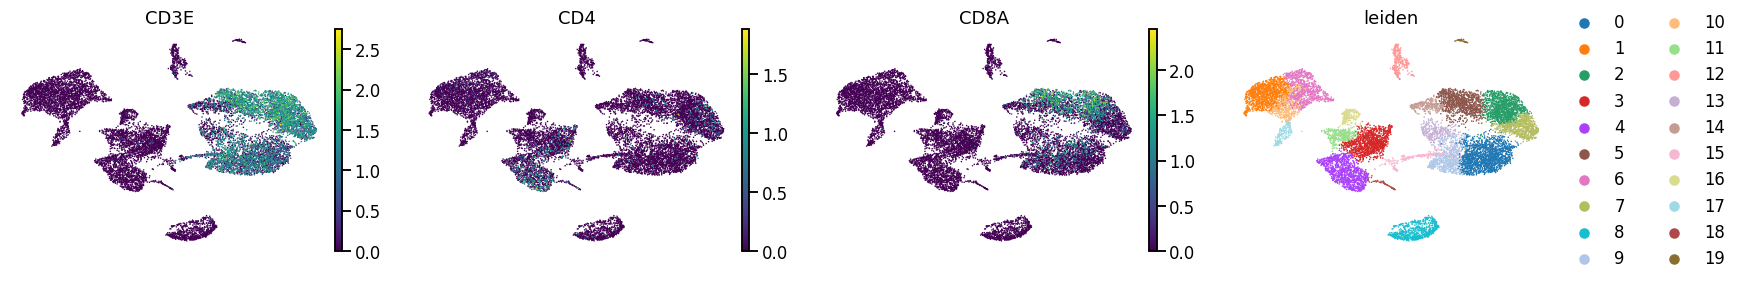

In [43]:
sc.pl.umap(adata, color=["CD3E", "CD4", "CD8A", "leiden"], frameon=False)

categories: 0, 1, 2, etc.
var_group_labels: T-cells, Naive T-cells, Memory CD4+ T-cells, etc.


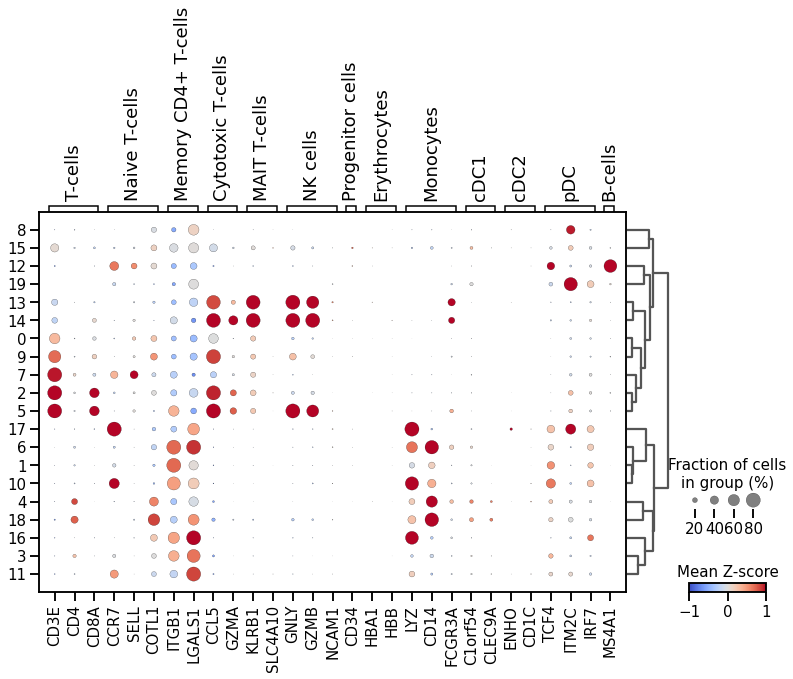

In [44]:
marker_genes_dict = {
    "T-cells" : ["CD3E", "CD4", "CD8A"],
    "Naive T-cells" : ["CCR7", "SELL", "COTL1"],
    "Memory CD4+ T-cells" : ["ITGB1", "LGALS1"],
    "Cytotoxic T-cells" : ["CCL5", "GZMA"],
    "MAIT T-cells" : ["KLRB1", "SLC4A10"],
    "NK cells" : ["GNLY", "GZMB", "NCAM1"],
    "Progenitor cells" : ["CD34"],
    "Erythrocytes" : ["HBA1", "HBB"],
    "Monocytes": ["LYZ", "CD14", "FCGR3A"],
    "cDC1" : ["C1orf54", "CLEC9A"],
    "cDC2" : ["ENHO", "CD1C"],
    "pDC" : ["TCF4", "ITM2C", "IRF7"],
    "B-cells" : ["MS4A1"]
}

adata_scaled = adata.raw.to_adata().copy()
adata_scaled.layers["scaled"] = sc.pp.scale(adata_scaled, copy=True).X
sc.pl.dotplot(adata_scaled, marker_genes_dict, "leiden", layer="scaled", dendrogram=True,
              vmin=-1, vmax=1, cmap="coolwarm", colorbar_title="Mean Z-score", dot_max=0.8)

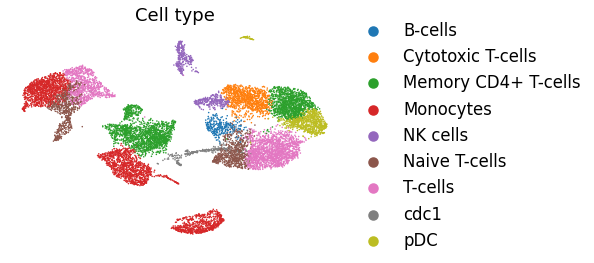

In [45]:
#sadly, the clustering changes everytime so the dictionary most probably
#will not relate to the clustering which we have now
#therefore I also inserted the picture of celltype assignment done before

#assigning cells based on the picture above is way too much arbitrary
#but let's assume they are distributed this way
leiden_to_ct = {
    "0" : "T-cells",
    "1" : "Monocytes",   
    "2" : "Memory CD4+ T-cells",    
    "3" : "Memory CD4+ T-cells",    
    "4" : "Monocytes",    
    "5" : "Cytotoxic T-cells",#
    "6" : "T-cells", 
    "7" : "pDC",   #c
    "8" : "Monocytes",   #c
    "9" : "Naive T-cells",
    "10" : "Naive T-cells",   #
    "11" : "Memory CD4+ T-cells",  
    "12" : "NK cells",  
    "13" : "B-cells", #c
    "14" : "NK cells",    
    "15" : "cdc1",
    "16" : "Memory CD4+ T-cells",   
    "17" : "Naive T-cells", # 
    "18" : "Monocytes",  
    "19" : "pDC" #c
}

adata.obs["cell_type"] = [leiden_to_ct[x] for x in adata.obs.leiden]
sc.pl.umap(adata, color="cell_type", frameon=False, title="Cell type")

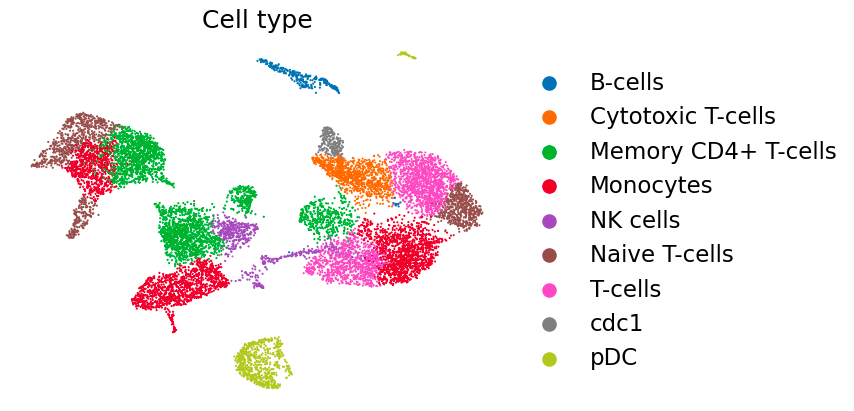

In [46]:
#cell assignemnt done in a previous run of notebook
Image('001.png')

Looks very unnatural which was to be expected since assignment was very arbitrary

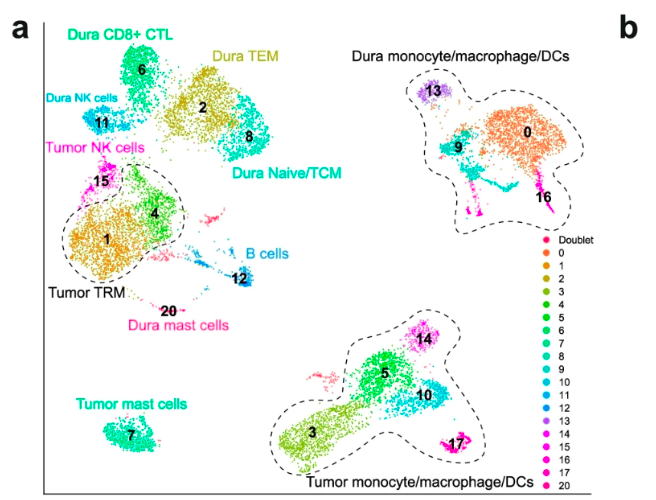

In [47]:
Image('002.png')

Clustering from researches looks very different. Only B-cells look somewhat similar

Предсказание типов клеток с помощью пакетов

In [48]:
adata_raw = sc.read_h5ad('combined_adata') # Загружаем сырую матрицу каунтов заново
#adata_raw = adata.copy()
adata_raw = adata_raw[ann_selected.index]
adata_raw.write_h5ad("PBMC_counts.h5ad") # Записываем её в виде объекта .h5ad
del adata_raw # Удаляем объект из памяти

#5114

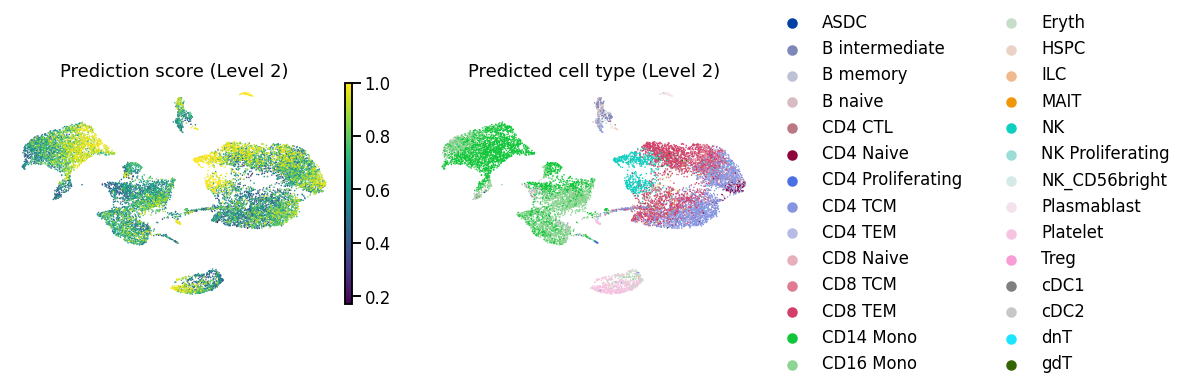

In [49]:
annotation = pd.read_csv("azimuth_pred.tsv", sep="\t", index_col=0)
for column in annotation:
    adata.obs[column] = annotation[column]
   # adata_sct.obs[column] = annotation[column]
    
sc.pl.umap(adata, color=["predicted.celltype.l2.score", "predicted.celltype.l2"],
           frameon=False, title=["Prediction score (Level 2)", "Predicted cell type (Level 2)"])

It looks much more plausible compared to the assignment done by hand previously. But still not much resablence to the picture the researchers have got

# Metrics calculation

In the article they use many different metrics which judge both integration and how well biological information is preserved. Then they calculate the aggregate function. We can't do that because there is only one batch and we don't have much information, but some metrics can be quickly calculated.

In [50]:
#tinkering to make the wrapper metrics calculation function work
adata.obs['batch'] = 1
adata.obs['batch'] =  adata.obs['batch'].astype('category')
adata_preint.obs['batch'] = 1
adata_preint.obs['batch'] =  adata_preint.obs['batch'].astype('category')
adata_preint.obs['cell_type']= [leiden_to_ct[x] for x in adata.obs.leiden]
adata_preint.obs['leiden'] = adata.obs['leiden']

In [51]:
#trying fast metrics
#adata - dataset after preprocessing. adata_preint - dataset before the preprocessing
scib.metrics.metrics_fast(adata_preint, adata, 'batch', 'leiden')

Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels ASW...
Graph connectivity...


,0
NMI_cluster/label,NaN
ARI_cluster/label,NaN
ASW_label,0.570927
ASW_label/batch,NaN
PCR_batch,0.000000
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.560409
graph_conn,1.000000
kBET,NaN


In [52]:
#computing selected metrics
metrics = {}
metrics['hvg_overlap'] = scib.metrics.hvg_overlap(adata_preint, adata, batch = 'batch') #there is only one batch
metrics['silhouette'] = scib.me.silhouette(adata = adata, group_key="leiden", embed = 'X_pca') #sklearn silhoutte
metrics['graph_connectivity'] = scib.metrics.graph_connectivity(adata, label_key = 'seurat_clusters') #connectivity by original research clusters
metrics['ari'] = scib.me.ari(adata, group1="leiden", group2="seurat_clusters")
metrics['nmi'] = scib.me.nmi(adata, group1="leiden", group2="seurat_clusters") #mutual information

In [53]:
metrics

{'hvg_overlap': 0.168,
 'silhouette': 0.5709268227219582,
 'graph_connectivity': 0.9906652885437671,
 'ari': 0.6186826274644953,
 'nmi': 0.7754184754360685}

# Clearing the memory

In [57]:
import gc
dir()
#del(mean)
#del(variance)
#del(confusion_matrix)
# del(data)
# del(mdata)
gc.collect()

12285

# Pipeline modifying

In [58]:
adata.obs['batch'] = 1
adata.obs['batch'] =  adata.obs['batch'].astype('category')
adata_preint.obs['batch'] = 1
adata_preint.obs['batch'] =  adata_preint.obs['batch'].astype('category')
adata.obs['seurat_clusters'] = ann_selected['seurat_clusters'].astype('category')
adata_preint.obs['seurat_clusters'] = ann_selected['seurat_clusters'].astype('category')

In [66]:
#saving and loading adata and adata_preint, just in case RAM crashes
adata.write('adata', compression = 'gzip')
adata_preint.write('adata_preint', compression = 'gzip')

In [68]:
gc.collect()

30

In [1]:
#cell with import of libraries in case RAM crashes

from IPython.display import Image, display, Markdown
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import rpy2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import time
import matplotlib.pyplot as plt
import os
import warnings
import copy
import anndata
import scanpy.external as sce
import scanpy as sc
import scib

In [2]:
os.chdir('/content/NGS_sc')
adata = sc.read_h5ad('adata')
adata_preint = sc.read_h5ad('adata_preint')
ann_selected = pd.read_csv('ann_selected.tsv', sep = '\t', index_col = 0)

/usr/local/lib/python3.8/dist-packages/h5py/_hl/dataset.py:767: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Writing a function which does the analysis but omits/modifies specified stages

In [3]:
#we need pca to do Leiden
def particial_pipeline(adata_preproc = adata_preint, log = True, scale = True, n_comp = 16, n_neighbors = 20, norm = True, HGV = 3000, leiden_resolution = 1, nmi_only = False):
    adata_inproc = adata_preproc.copy()
    adata_preproc = adata_preproc.copy()
    if norm:
        sc.pp.normalize_total(adata_inproc)
    if log:
        sc.pp.log1p(adata_inproc) 

    sc.pp.highly_variable_genes(
        adata_inproc,
        n_top_genes = HGV,
        flavor="seurat_v3",
    )
    
    if scale:
        sc.pp.scale(adata_inproc)
    
    sc.tl.pca(adata_inproc)
    sc.pp.neighbors(adata_inproc, n_pcs=n_comp, n_neighbors= n_neighbors)    
    sc.tl.leiden(adata_inproc, resolution = leiden_resolution)
    
    #computing the following metrics by default
    if not nmi_only:
        metrics = {}
        metrics['hvg_overlap'] = scib.metrics.hvg_overlap(adata_preproc, adata_inproc, batch = 'batch') #there is only one batch
        metrics['silhouette'] = scib.me.silhouette(adata = adata_inproc, group_key="leiden", embed = 'X_pca') #sklearn silhoutte
        metrics['graph_connectivity'] = scib.metrics.graph_connectivity(adata_inproc, label_key = 'seurat_clusters') #connectivity by original research clusters 
        metrics['ari'] = scib.me.ari(adata_inproc, group1="leiden", group2="seurat_clusters")
        metrics['nmi'] = scib.me.nmi(adata_inproc, group1="leiden", group2="seurat_clusters") #mutual information
    
    #this is for the next task of searching hyperparameters
    if nmi_only:
        metrics = scib.me.nmi(adata_inproc, group1="leiden", group2="seurat_clusters")
        
    
    return metrics

First, doing it the most minimalistic way possible.
No log1p, no scaleing, 1000 HGV, no normalizing, only 2 pca components

In [4]:
#note: for some reasons sometimes the function displays error, sometimes not for the same call
particial_pipeline(adata_preint, log = False, scale = False, n_comp = 2, norm = False, HGV = 1000)

{'hvg_overlap': 1.0,
 'silhouette': 0.4387051500380039,
 'graph_connectivity': 0.3084882147904501,
 'ari': 0.055073918445953676,
 'nmi': 0.24772000943724853}

Now, let's try different resolution and smaller number of neighbors

In [ ]:
particial_pipeline(adata_preint, n_neighbors = 20, leiden_resolution = np.e, nmi_only = True)

0.7335179067551936

No Scale

In [ ]:
#might fail sometimes, but precomputed metrics are already below
#particial_pipeline(scale = False)

/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


{'hvg_overlap': 0.15568862275449102,
 'silhouette': 0.5627146512269974,
 'graph_connectivity': 0.9573359383079106,
 'ari': 0.5692794165092616,
 'nmi': 0.7518414641393754}

Many pca_components

In [ ]:
#might fail sometimes, but precomputed metrics are already below
#particial_pipeline(n_comp = 50)

/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


{'hvg_overlap': 0.06387225548902195,
 'silhouette': 0.5774187073111534,
 'graph_connectivity': 0.9923198849942525,
 'ari': 0.6923170424598568,
 'nmi': 0.8134456449318171}

Too few pca_components

In [ ]:
#might fail sometimes, but precomputed metrics are already below
#particial_pipeline(n_comp = 3)

/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


{'hvg_overlap': 0.06387225548902195,
 'silhouette': 0.49103349447250366,
 'graph_connectivity': 0.8560175453956851,
 'ari': 0.2922155791375276,
 'nmi': 0.5850468568940804}

No log1p

In [5]:
particial_pipeline(log = False, nmi_only = True)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


0.7541335962684831

Interestingly enough, increasing the number of principal components in PCA improved the mutual information between my clustering and clustering of researchers a lot. They probably didn't truncate pca much. Getting rid of norm, log and scale had a negative effect.

# Searching for the best parameters

I will use number of neighbors, pca components, HGV as parameters. 

Doing gradient descent here isn't feasible because values are descerete. So I just will be changing the parameters either incrementally increasing or decreasing them until no improvement in a single step can be found. Or until the maximum number of iterations is reached.

Mutual information is used as the metrics.

In [7]:
import gc
def sidestep_search(neighbors_start = 20, ncomp_start = 20, HGV_start = 2100, max_steps = 12):
    
    metrics_best = particial_pipeline(n_comp = ncomp_start, n_neighbors = neighbors_start, HGV = HGV_start, nmi_only = True)
    
    ncomp_best = ncomp_start
    neighbors_best = neighbors_start
    HGV_best = HGV_start
    print(f'new best result. nn = {neighbors_best}, ncomp = {neighbors_best}, HGV = {HGV_best}')
    
    '''
    since there is 3 metrics, there is only 6 directions where optimization can be moved. 
    However, iterating through all of them until local maximum is found would take too long, 
    so, as the prove of concept, I'm going to do the exhaustive search and severely limit 
    the algorithm instead.
    '''
    step = 0
    
    #For proving the concept. Limiting max number of steps in each direction tried
    steps_tried = {'decr_pca': 0,
                  'incr_pca': 0,
                  'decr_nn':0, #number of neighbors
                  'incr_nn':0,
                  'decr_HGV':0,
                  'incr_HGV':0,} 
    max_steps_tried = {'decr_pca': 0,
                  'incr_pca': 0,
                  'decr_nn':0, #number of neighbors
                  'incr_nn':0,
                  'decr_HGV':0,
                  'incr_HGV':0,} 
    
     
    while True:
        step += 1
        
        #direction of decreasing ncomp
        if steps_tried['decr_pca'] < 5: #prove of concept so limited to 2, otherwise this and the next line wouldn't be there
            steps_tried['decr_pca'] += 1
            metrics_check = particial_pipeline(n_comp = ncomp_best - 4, n_neighbors = neighbors_best, HGV = HGV_best, nmi_only = True)
            if metrics_check > metrics_best:
                ncomp_best -= 4
                metrics_best = metrics_check
                print(f'new best result nmi = {metrics_check}. nn = {neighbors_best}, ncomp = {ncomp_best}, HGV = {HGV_best}')
            else: 
                print(f'tried. nn = {neighbors_best}, ncomp = {ncomp_best-4}, HGV = {HGV_best}, the metric is worse and is {metrics_check}')
            gc.collect()
                
         #direction of increasing ncomp       
        if steps_tried['incr_pca'] < 5:
            steps_tried['incr_pca'] += 1
            metrics_check = particial_pipeline(n_comp = ncomp_best + 4, n_neighbors = neighbors_best, HGV = HGV_best, nmi_only = True)
            if metrics_check > metrics_best:
                ncomp_best += 4
                metrics_best = metrics_check
                print(f'new best result nmi = {metrics_check}. nn = {neighbors_best}, ncomp = {ncomp_best}, HGV = {HGV_best}')
            else: 
                print(f'tried. nn = {neighbors_best}, ncomp = {ncomp_best+4}, HGV = {HGV_best}, the metric is worse and is {metrics_check}')
            gc.collect()
         
        #direction of decreasing neighbors  
        if steps_tried['decr_nn'] < 5:
            steps_tried['decr_nn'] += 1
            metrics_check = particial_pipeline(n_comp = ncomp_best, n_neighbors = neighbors_best - 3, HGV = HGV_best, nmi_only = True)
            if metrics_check > metrics_best:
                neighbors_best -= 3
                metrics_best = metrics_check
                print(f'new best result nmi = {metrics_check}. nn = {neighbors_best}, ncomp = {ncomp_best}, HGV = {HGV_best}')
            else: 
                print(f'tried. nn = {neighbors_best-3}, ncomp = {ncomp_best}, HGV = {HGV_best}, the metric is worse and is {metrics_check}')
            gc.collect()
                
        #direction of increasing neighbors         
        if steps_tried['incr_nn'] < 5:
            steps_tried['incr_nn'] += 1
            metrics_check = particial_pipeline(n_comp = ncomp_best, n_neighbors = neighbors_best + 3, HGV = HGV_best, nmi_only = True)
            if metrics_check > metrics_best:
                neighbors_best += 3
                metrics_best = metrics_check
                print(f'new best result nmi = {metrics_check}. nn = {neighbors_best}, ncomp = {ncomp_best}, HGV = {HGV_best}')
            else: 
                print(f'tried. nn = {neighbors_best+3}, ncomp = {ncomp_best}, HGV = {HGV_best}, the metric is worse and is {metrics_check}')
            gc.collect()
                
        #direction of decreasing HGV                 
        if steps_tried['decr_HGV'] < 5:
            steps_tried['decr_HGV'] += 1
            metrics_check = particial_pipeline(n_comp = ncomp_best, n_neighbors = neighbors_best, HGV = HGV_best - 100, nmi_only = True)
            if metrics_check > metrics_best:
                HGV_best -= 100
                metrics_best = metrics_check
                print(f'new best result nmi = {metrics_check}. nn = {neighbors_best}, ncomp = {ncomp_best}, HGV = {HGV_best}')
            else: 
                print(f'tried. nn = {neighbors_best}, ncomp = {ncomp_best}, HGV = {HGV_best-100}, the metric is worse and is {metrics_check}')
            gc.collect()
         
        #direction of increasing HGV   
        if steps_tried['incr_HGV'] < 5:
            steps_tried['incr_HGV'] += 1
            metrics_check = particial_pipeline(n_comp = ncomp_best, n_neighbors = neighbors_best, HGV = HGV_best + 100, nmi_only = True)
            if metrics_check > metrics_best:
                HGV_best += 100
                metrics_best = metrics_check
                print(f'new best result nmi = {metrics_check}. nn = {neighbors_best}, ncomp = {ncomp_best}, HGV = {HGV_best}')
            else: 
                print(f'tried. nn = {neighbors_best}, ncomp = {ncomp_best}, HGV = {HGV_best+100}, the metric is worse and is {metrics_check}')
            gc.collect()
                
                  
        
        if step >= max_steps:
            break

    print()   
    print('done') 
    print(f'best result: nmi = {metrics_check}. nn = {neighbors_best}, ncomp = {ncomp_best}, HGV = {HGV_best}') 

In [8]:
import gc
gc.collect()

1247

In [9]:
#sadly, the function can't fully run because of RAM problem. But overall, it works.
import warnings
warnings.filterwarnings('ignore')
sidestep_search(neighbors_start = 20, ncomp_start = 20, HGV_start = 2100, max_steps = 12)

new best result. nn = 20, ncomp = 20, HGV = 2100
new best result nmi = 0.7926170614717793. nn = 20, ncomp = 16, HGV = 2100
tried. nn = 24, ncomp = 16, HGV = 2100, the metric is worse and is 0.783456546047428
tried. nn = 17, ncomp = 16, HGV = 2100, the metric is worse and is 0.7742098786821747
tried. nn = 23, ncomp = 16, HGV = 2100, the metric is worse and is 0.7898745805124333
new best result nmi = 0.7942323794256947. nn = 20, ncomp = 16, HGV = 2000
tried. nn = 20, ncomp = 16, HGV = 2100, the metric is worse and is 0.7926170614717793
tried. nn = 20, ncomp = 12, HGV = 2000, the metric is worse and is 0.7725815771655811
tried. nn = 24, ncomp = 16, HGV = 2000, the metric is worse and is 0.785820479601853
tried. nn = 17, ncomp = 16, HGV = 2000, the metric is worse and is 0.7851752924058794
tried. nn = 23, ncomp = 16, HGV = 2000, the metric is worse and is 0.7898763374697346
tried. nn = 20, ncomp = 16, HGV = 1900, the metric is worse and is 0.793260985172475
tried. nn = 20, ncomp = 16, HGV 